# 비트코인 예측하기
 ## 시계열 데이터 분석
 - 연속적인 시간에 따라 다르게 측정되는 데이터 > 시계열 데이터

## Step1. 시간정보가 포함된 데이터 살펴보기

In [18]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
file_path = 'market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
# Step1. 탐색 : 시간정보가 포함된 데이터 살펴보기
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(366, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     366 non-null    object 
 1   price   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [2]:
bitcoin_df.tail()

,day,price
361,2020-07-17 00:00:00,9131.00
362,2020-07-18 00:00:00,9154.19
363,2020-07-19 00:00:00,9174.71
364,2020-07-20 00:00:00,9214.66
365,2020-07-21 00:00:00,9163.87


In [3]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터 프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2019-07-22,10587.41
2019-07-23,10323.62
2019-07-24,9844.30
2019-07-25,9772.17
2019-07-26,9875.17


In [4]:
bitcoin_df.describe()

,price
count,366.000000
mean,8718.217322
std,1312.569856
min,4830.210000
25%,7637.620000
50%,8911.835000
75%,9623.185000
max,11996.410000


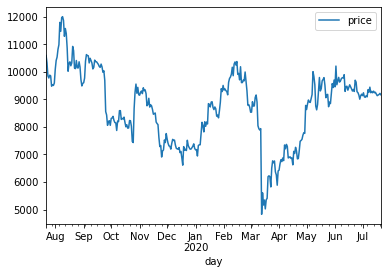

In [5]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

# Step2 예측 : 파이썬 라이브러리를 활용하여 시세 예측하기

In [6]:
# AR 모델 자기 자신의 과거를 정보로 사용하는 개념
# MA 모델 이전항에서 오차를 이용하여 현재항의 상태를 추론하는 방법
# AR 모델+ MA 모델 = ARIMA 모델 + 추세 변동의 경향성
# statsmodel 모듈로 ARIMA분석 수행 가능
# order=(2,1,2) # AR이 몇번째 까지 보는지 / 차이에 대한 파라미터 / MA가 몇번째 까지 보는지
# AR 과 MA를 2로 설정->p-value가 0.05이하-> 유의미한 데이터

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit=model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2624.578
Method:                       css-mle   S.D. of innovations            321.053
Date:                Tue, 28 Jul 2020   AIC                           5261.156
Time:                        12:33:39   BIC                           5284.556
Sample:                             1   HQIC                          5270.455
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9176     16.561     -0.237      0.813     -36.376      28.540
ar.L1.D.y     -1.3024      0.450     -2.894      0.004      -2.185      -0.420
ar.L2.D.y     -0.4667      0.335     -1.395      0.1

In [8]:
# ARIMA 분석의 파라미터
# p와 q의 합이 2미만인 경우, 곱이 0을 포함한 짝수인 경우의 파라미터 조합을 사용->가이드라인

<AxesSubplot:>

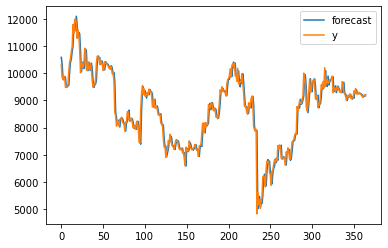

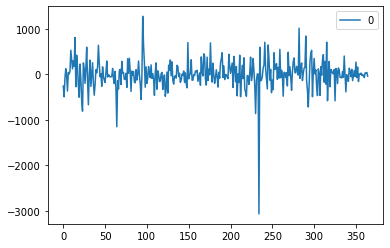

In [9]:
fig=model_fit.plot_predict() #학습데이터에 대한 예측결과
residuals=pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다.
residuals.plot()

In [10]:
# 두번째 그래프는 실제값과 예측값 사이의 오차 변동
# ARIMA 모델 평가 -> 테스트 전용 데이터 ->앞으로 N일동안 어느정도 상승/하락할지 대략적 경향 예측
forecast_data=model_fit.forecast(steps=5) # 학습데이터셋으로부터 5일뒤 예측
test_file_path='market-price-test.csv'
bitcoin_test_df=pd.read_csv(test_file_path, names=['ds','y'])

pred_y=forecast_data[0].tolist() # 마지막 5일의 예측 데이터 7/17~7/21
test_y=bitcoin_test_df.y.values #실제 5일 가격 데이터 <= 18/8/27~18/8/21 ====여기에 데이터 업데이트 하면 됨
pred_y_lower= [] # 마지막 5일의 예측 데이터 최소값
pred_y_upper=[] # 마지막 5일의 예측 데이터 최댓값
for lower_upper in forecast_data[2]:
    lower=lower_upper[0]
    upper=lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

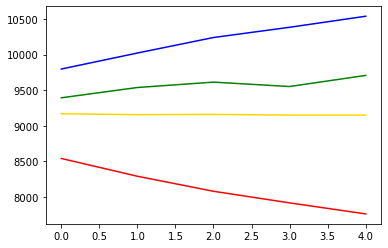

In [11]:
plt.plot(pred_y,color="gold") # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예측한 최저 가격
plt.plot(pred_y_upper, color="blue") # 모델이 예측한 최고 가격
plt.plot(test_y, color="green") # 실제 가격 그래프 -> test_y 기반

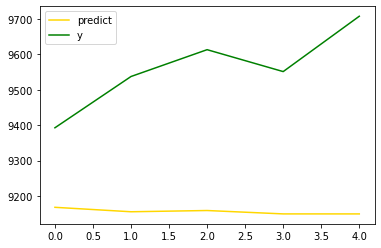

In [12]:
plt.plot(pred_y, color="gold") #모델이 예상한 가격 그래프
plt.plot(test_y,color="green") # 실제 가격 그래프
plt.legend(['predict','y'])

### Facebook prophet 활용하기

In [13]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [14]:
bitcoin_df=pd.read_csv(file_path, names=['ds','y']) # 데이터 피처를 ds,y 로 변경해야한다.
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True, daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df) # fit 함수로 모델을 학습시킵니다.

In [15]:
future_data=prophet.make_future_dataframe(periods=5, freq='d') # make_future_dataframe() 5일 예측 데이터 얻을 수 있다.
forecast_data=prophet.predict(future_data) # 학습데이터에 대한 예측
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
366,2020-07-22,9720.080204,9169.285762,10249.899592
367,2020-07-23,9835.790410,9325.422119,10418.744944
368,2020-07-24,9907.451076,9363.432526,10427.046793
369,2020-07-25,10034.296406,9502.332078,10595.225682
370,2020-07-26,10110.524201,9569.758114,10633.675172


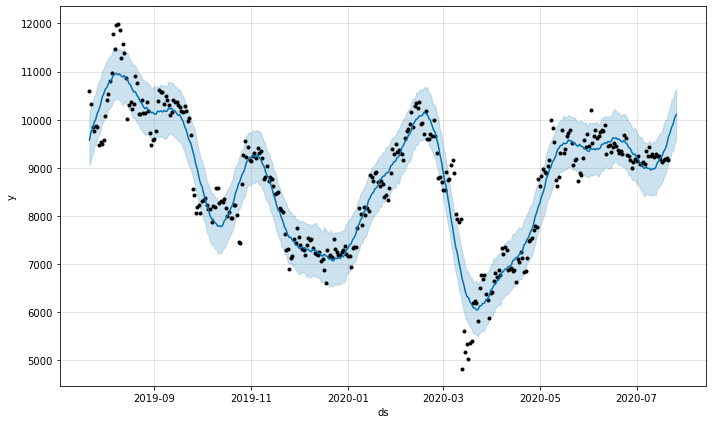

In [16]:
fig1=prophet.plot(forecast_data) 

c:\anaconda3\envs\pybook\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
c:\anaconda3\envs\pybook\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
c:\anaconda3\envs\pybook\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


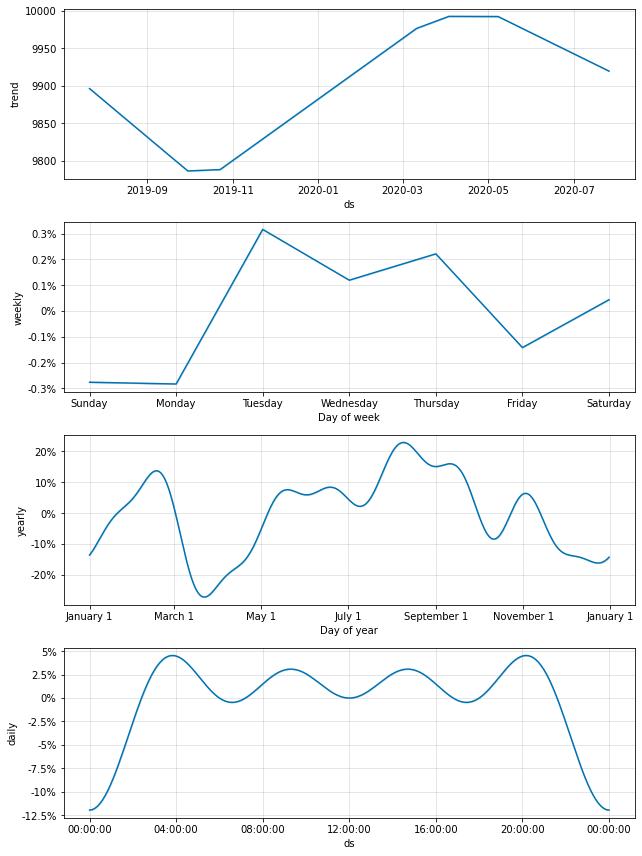

In [17]:
fig2=prophet.plot_components(forecast_data)

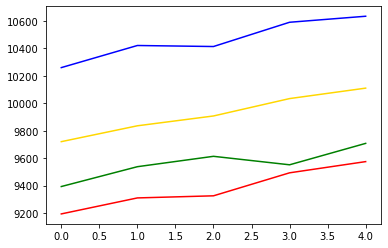

In [20]:
bitcoin_test_df=pd.read_csv(test_file_path, names=['ds','y']) # 데이터 피처를 ds,y 로 변경해야한다.

# 마지막 5일의 예측 데이터입니다. (2020-07-22 ~ 2020-07-26)
pred_y=forecast_data.yhat.values[-5:]
# 실제 5일 가격 데이터입니다.  (2020-07-22 ~ 2020-07-26)
test_y=bitcoin_test_df.y.values
# 마지막 5일의 예측 데이터의 최솟값 입니다.
pred_y_lower=forecast_data.yhat_lower.values[-5:]
# 마지막 5일의 예측 데이터의 최댓값 입니다.
pred_y_upper=forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최저 가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최고 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프


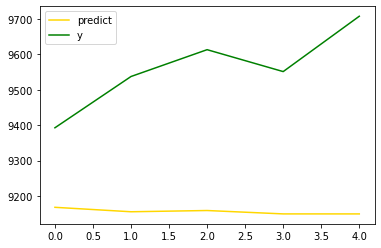

In [21]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프
plt.legend(['predict','y'])

In [25]:
# 테스트 데이터의 RMSE를 출력합니다.
## from sklearn.metrics import mean_squared_errpr
# rmse = sqrt(mean_squared_error(pred_y, test_y))
# print(rmse)

## Step3. 상한값 혹은 하한값을 지정하기

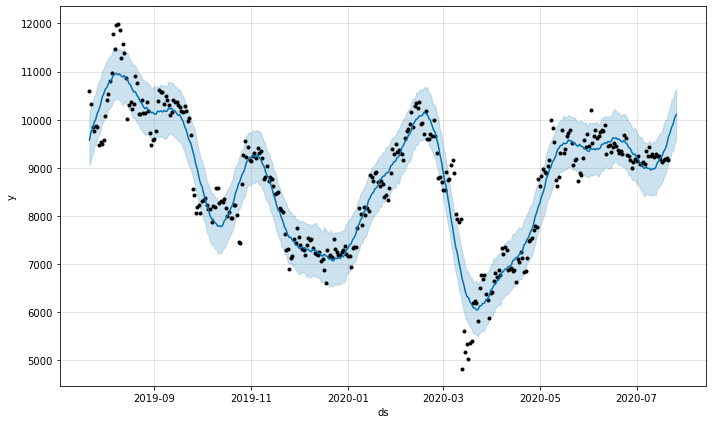

In [28]:
# future_data['cap']=20,000 : 데이터 셋에 상한선을 설정

bitcoin_df=pd.read_csv(file_path, names=['ds','y'])
bitcoin_df['cap']=20000
prophet=Prophet(seasonality_mode='multiplicative',
               growth='logistic',
               yearly_seasonality=True,
               weekly_seasonality=True,
               daily_seasonality=True,
               changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일을 내다보며 예측합니다.
future_Data=prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap']=12000
forecase_data=prophet.predict(future_data)
fig=prophet.plot(forecast_data)

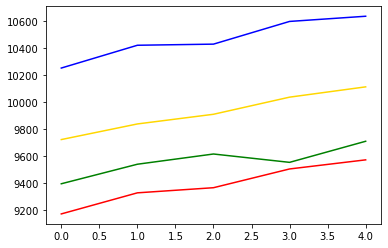

In [29]:
# 예측과 실제 비교 그래프
bitcoin_test_df=pd.read_csv(test_file_path, names=['ds','y'])

# 모델이 예측한 마지막 일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y=bitcoin_test_df.y.values
pred_y_lower=forecast_data.yhat_lower.values[-5:]
pred_y_upper=forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예측한 가격 그래프 입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예측한 하한가 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예측한 상한가 그래프 입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프 입니다.

In [30]:
# 모델이 예측한 상한가 보다 실제 가격이 높다-> 의미없는 정보
# 비트코인은 상한가 개념을 도입하면 정확도가 하락한다.
# 울타리밖 데이터-> 이상치 데이터
# 이상치 데이터 제거 방법->이상치 데이터 None으로 설정

In [35]:
bitcoin_df=pd.read_csv(file_path, names=['ds','y'])
bitcoin_df.loc[bitcoin_df['y']>12000,'y']=None

# prophet 모델을 학습
prophet=Prophet(seasonality_mode='multiplicative',
               yearly_seasonality=True,
               weekly_seasonality=True,
               daily_seasonality=True,
               changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

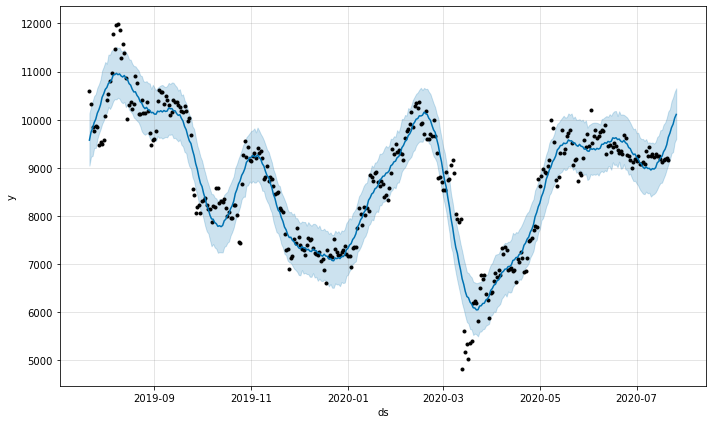

In [40]:
# 5일 단위 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측결과를 그래프로 출력합니다.
fig=prophet.plot(forecast_data)

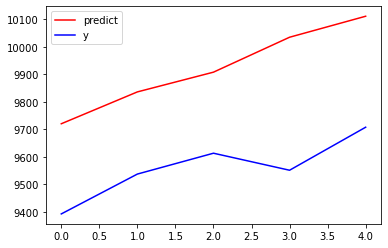

In [51]:
# ls="--", marker="o", ms=5# 
plt.plot(pred_y, color="red") # 모델이 예측한 가격 그래프
plt.plot(test_y, color="blue") #실제 가격 그래프
plt.legend(['predict','y'])

In [53]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
# 결론: 정확도(RMSE) 면에서는 떨어지지만 트렌드를 예측하는 측면에서는 이전보다 낫다
rmse=sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

368.4048998190358
